This is a PySR run on a synthetic molecular mass dataset generated using the Goossens Correlation and the limits of the Goossens dataset.

In [1]:
# Call Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive
from pysr import PySRRegressor
import time
import sympy as sym
from scipy.stats import shapiro
from scipy.stats import kstest
import statsmodels.api as sm

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# Colab
#drive.mount('/content/drive')
#df=pd.read_csv('/content/drive/MyDrive/goossens_raw.csv')
# Positron
df=pd.read_csv('./goossens_raw.csv')
# Quarto
#df=pd.read_csv('./c694/goossens_raw.csv')

mw_min=min(df['MW'])
mw_max=max(df['MW'])
sg_min=min(df['SG'])
sg_max=max(df['SG'])
tb_min=min(df['TBP'])
tb_max=max(df['TBP'])


In [3]:
# Set up Random Number Generator
rng = np.random.default_rng(seed=123)
# Generate random specific gravities
new_sg=rng.random(size=2500)*(sg_max-sg_min)+sg_min
# Generate random boiling points
new_tb=rng.random(size=2500)*(tb_max-tb_min)+tb_min

In [4]:
# Goossens Correlation
def goos_Mw(sg,tbp):
  c0 = 0.01077
  c1 = 1.52869
  c2 = 0.06486
  c3 = 1078.0
  c4 = 0.0
  c5 = 1.002733049
  c6 = -0.006433370483
  t=tbp # No conversion necessary
  c4 = c1 + c2 * np.log(t / (c3 - t))
  return c0 * (t ** c4) / (sg * c5 + c6)

# Synthetic Molecular Mass
new_mw=np.zeros(2500)
for i in range(2500):
    new_mw[i]=goos_Mw(new_sg[i],new_tb[i]) 

# Build Dataframe between molecular mass limits
data={
    "SG":new_sg,
    "TB":new_tb,
    "MW":new_mw
}
df0=pd.DataFrame(data)
df=df0[(df0['MW']>mw_min) & (df0['MW']<mw_max)]
df.describe()

,SG,TB,MW
count,2268.000000,2268.000000,2268.000000
mean,0.989730,684.761811,414.502589
std,0.211165,183.420614,332.884012
min,0.631139,317.337562,70.224691
25%,0.809334,534.557744,162.862235
50%,0.982418,686.322252,302.929748
75%,1.164466,840.848284,559.103847
max,1.379007,1011.429854,1679.645442


<function matplotlib.pyplot.show(close=None, block=None)>

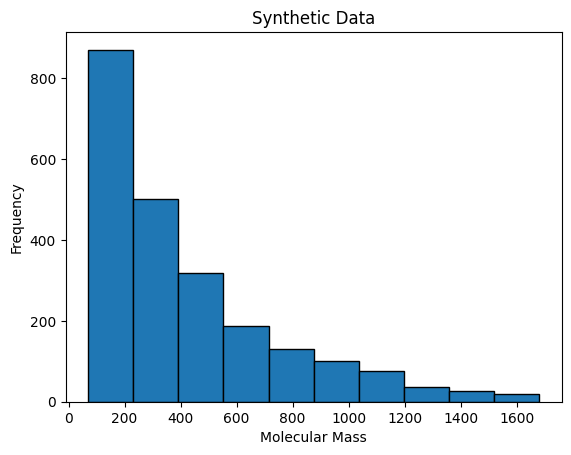

In [5]:
plt.hist(df['MW'],edgecolor="black")
plt.title("Synthetic Data")
plt.xlabel("Molecular Mass")
plt.ylabel("Frequency")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

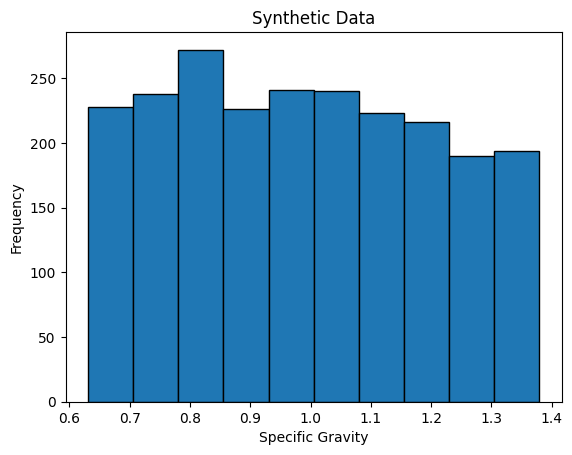

In [6]:
plt.hist(df['SG'],edgecolor="black")
plt.title("Synthetic Data")
plt.xlabel("Specific Gravity")
plt.ylabel("Frequency")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

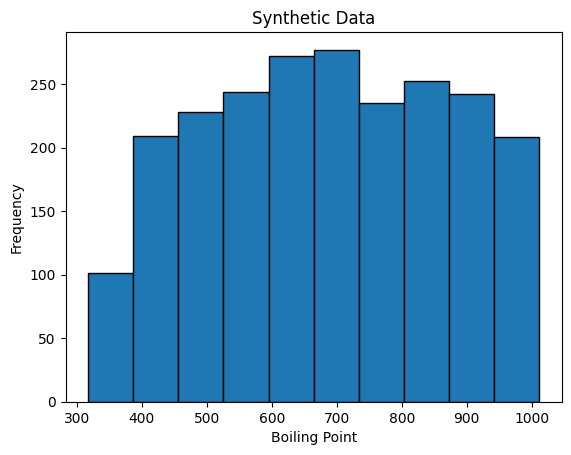

In [7]:
plt.hist(df['TB'],edgecolor="black")
plt.title("Synthetic Data")
plt.xlabel("Boiling Point")
plt.ylabel("Frequency")
plt.show

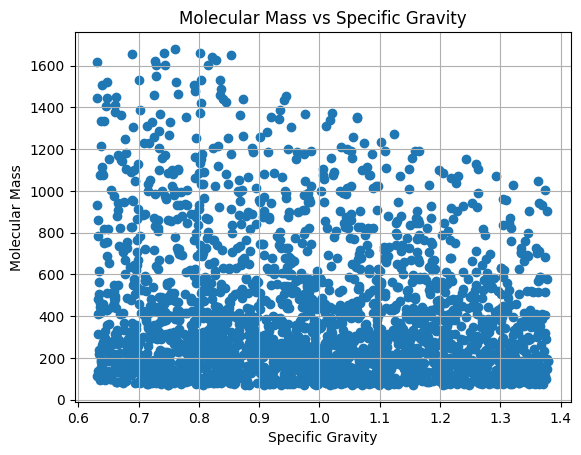

In [8]:
plt.scatter(df['SG'],df['MW'])
plt.title("Molecular Mass vs Specific Gravity")
plt.xlabel("Specific Gravity")
plt.ylabel("Molecular Mass")
plt.grid()
plt.show()

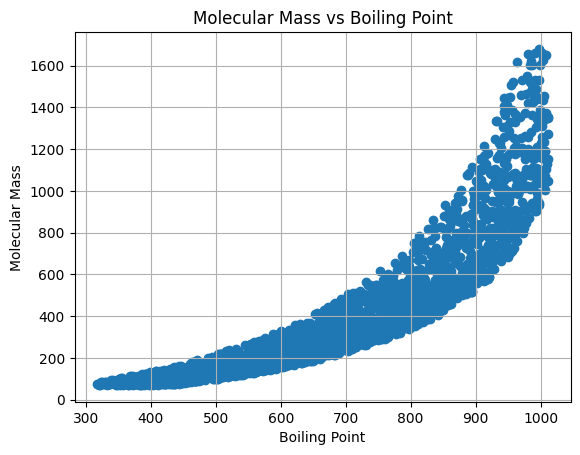

In [9]:
plt.scatter(df['TB'],df['MW'])
plt.title("Molecular Mass vs Boiling Point")
plt.xlabel("Boiling Point")
plt.ylabel("Molecular Mass")
plt.grid()
plt.show()

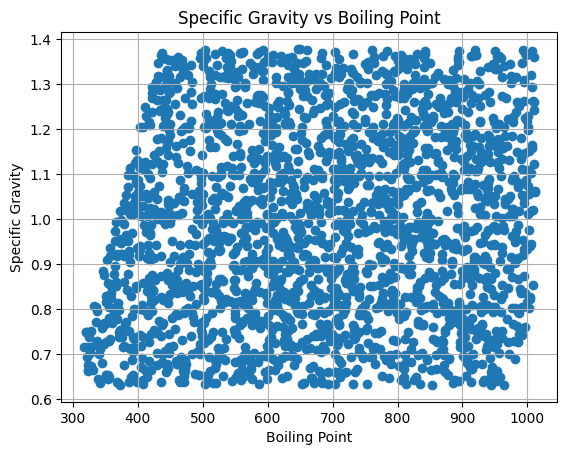

In [10]:
plt.scatter(df['TB'],df['SG'])
plt.title("Specific Gravity vs Boiling Point")
plt.xlabel("Boiling Point")
plt.ylabel("Specific Gravity")
plt.grid()
plt.show()

In [11]:
y=df['MW']
x=df[['SG','TB']]
t0 = time.time()
myMod=PySRRegressor(random_state=7,
    deterministic=True,
    parallelism='serial',
#myMod=PySRRegressor(
    niterations=1000,
    binary_operators=["+","-","*","/"],
    unary_operators=["exp","log"])
myMod.fit(x,y)
print("time to fit: ",time.time() - t0, 'seconds')
y_pred=myMod.predict(x)

/home/richard/Documents/p312a/lib/python3.12/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 5.490e+04
Progress: 236 / 31000 total iterations (0.761%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.108e+05  0.000e+00  y = 414.51
3           3.799e+04  5.293e-01  y = TB + -270.24
5           2.660e+04  1.768e-01  y = -668.77 - (TB * -1.582)
7           1.651e+04  2.369e-01  y = ((TB * 1.4974) - 625.01) / SG
8           1.635e+04  8.828e-03  y = (exp(0.42428 / SG) * TB) + -660.42
9           7.391e+03  7.929e-01  y = (TB * 0.0017622) * (TB - (SG * 394.4))
11          7.382e+03  3.507e-04  y = SG - (((TB - (SG * 395.8)) * TB) * -0.0017622)
12          7.160e+03  3.007e-02  y = TB * (((TB * 0.0017741) - (-1.8574 / exp(SG))) - 1.402...
                                      9)
13          6.596e+03  8.147e-02  y = 0.72449 + ((312.85 - TB) * 

[ Info: Final population:
[ Info: Results saved to:


time to fit:  798.6787722110748 seconds
  - outputs/20250729_105317_yGrjfP/hall_of_fame.csv


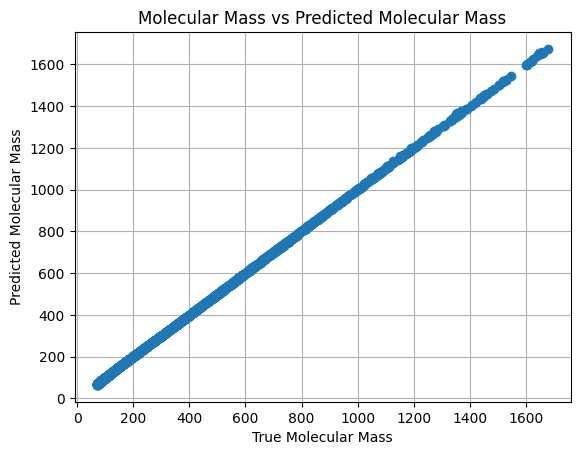

In [12]:
plt.plot(y,y_pred,marker="o",linestyle="None")
plt.xlabel('True Molecular Mass')
plt.ylabel('Predicted Molecular Mass')
plt.title('Molecular Mass vs Predicted Molecular Mass')
plt.grid()
plt.show()

In [13]:
# Pull Out Winning Equation
myEq=myMod.sympy()
print(myEq)

(-44.603092 - 40.15523/(log(TB) - 7211.8213/TB) + 1471.2992/(-5.856805 + 7064.4985/TB))/SG


In [14]:
# Consolidate Equaton
sym.simplify(myEq)

-(44.603092 + 40.15523/(log(TB) - 7211.8213/TB) + 1471.2992/(5.856805 - 7064.4985/TB))/SG

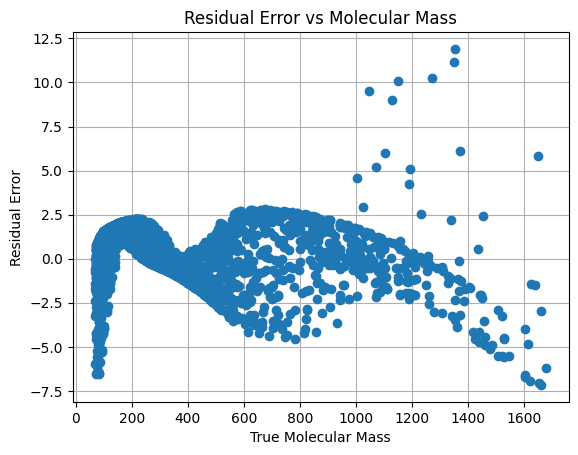

In [15]:
# Calculate Residuals
dely=y_pred-y
#df['Fit_Mw']=y_pred
#df['Error']=dely

plt.plot(y,dely,marker="o",linestyle="None")
plt.xlabel('True Molecular Mass')
plt.ylabel('Residual Error')
plt.title('Residual Error vs Molecular Mass')
plt.grid()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

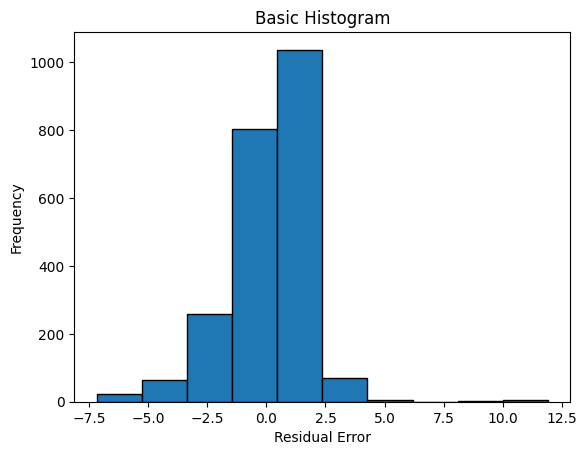

In [16]:
# Normality Test #1
plt.hist(dely,edgecolor="black")
plt.title("Basic Histogram")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show

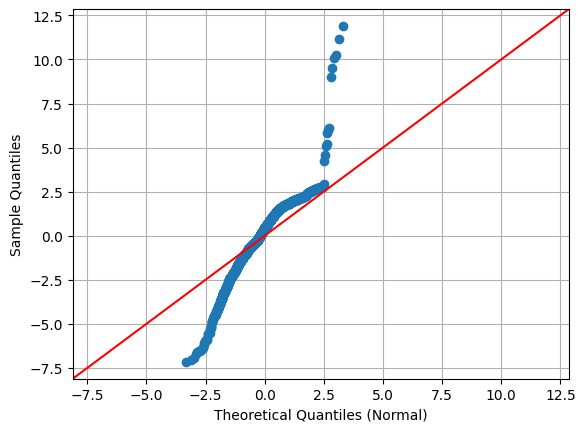

In [17]:
# Normality Test #2
fig = sm.qqplot(dely, line='45')
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

In [18]:
# Normality Test #3
shapiro(dely)

ShapiroResult(statistic=np.float64(0.9282741082543515), pvalue=np.float64(1.1923794526939493e-31))

In [19]:
# Normality Test #4
kstest(dely,'norm')

KstestResult(statistic=np.float64(0.22812471076701302), pvalue=np.float64(3.206717083364177e-104), statistic_location=np.float64(1.182840738831345), statistic_sign=np.int8(-1))

In [20]:
df['Fit_Mw']=y_pred
df['Resid']=dely
df.describe()

<positron-console-cell-20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-20>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SG,TB,MW,Fit_Mw,Resid
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000
mean,0.989730,684.761811,414.502589,414.699770,0.197181
std,0.211165,183.420614,332.884012,332.562237,1.792749
min,0.631139,317.337562,70.224691,64.778823,-7.160955
25%,0.809334,534.557744,162.862235,164.926885,-0.745151
50%,0.982418,686.322252,302.929748,303.194184,0.429340
75%,1.164466,840.848284,559.103847,558.636034,1.551687
max,1.379007,1011.429854,1679.645442,1673.417557,11.903180


In [21]:
df.corr()

,SG,TB,MW,Fit_Mw,Resid
SG,1.000000,0.127854,-0.171696,-0.169868,0.369849
TB,0.127854,1.000000,0.871673,0.872205,-0.057768
MW,-0.171696,0.871673,1.000000,0.999986,-0.182093
Fit_Mw,-0.169868,0.872205,0.999986,1.000000,-0.176878
Resid,0.369849,-0.057768,-0.182093,-0.176878,1.000000
